In [63]:
import pandas as pd

In [64]:
tenis_df = pd.read_csv("dane/Dane_ATP_2000-2024 d.csv", sep=';')

In [65]:
print(tenis_df.columns)

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')


In [66]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')

73247 liczba rowow, powinno byc 73247


In [67]:
tenis_df.head(5)

tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0   2000-301     Auckland    Hard         32             A      20000110   
1   2000-301     Auckland    Hard         32             A      20000110   
2   2000-301     Auckland    Hard         32             A      20000110   
3   2000-301     Auckland    Hard         32             A      20000110   
4   2000-301     Auckland    Hard         32             A      20000110   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0          1     103163          1.0          NaN  ...    55.0     39.0   
1          2     102607          NaN            Q  ...    32.0     25.0   
2          3     103252          NaN          NaN  ...    33.0     20.0   
3          4     103507          7.0          NaN  ...    43.0     29.0   
4          5     102103          NaN            Q  ...    46.0     34.0   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0      29.0    17.0        4.0        7.0         11.0             1612.0   
1      18.0    12.0        3.0        6.0        211.0              157.0   
2       7.0     8.0        7.0       11.0         48.0              726.0   
3      14.0    10.0        6.0        8.0         45.0              768.0   
4      18.0    12.0        5.0        9.0        167.0              219.0   

  loser_rank loser_rank_points  
0       63.0             595.0  
1       49.0             723.0  
2       59.0             649.0  
3       61.0             616.0  
4       34.0             873.0  

[5 rows x 49 columns]

<Axes: ylabel='count'>

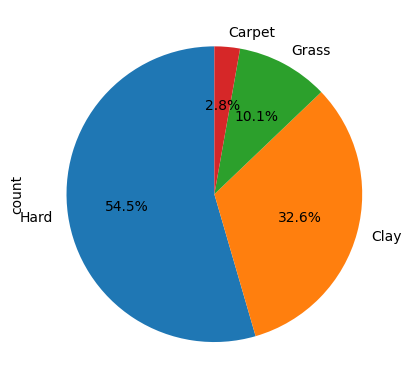

In [68]:
# Wizualizujemy rozklad roznych powierzchni
tenis_df = tenis_df.dropna(subset=['surface'])
surface = tenis_df['surface'].value_counts()
surface.plot(kind='pie', autopct='%1.1f%%', startangle=90)

In [69]:
# Zamieniamy kolumny statystyk meczowych na ich rolling values
# Listy kolumn do przetworzenia
stats = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
columns_for_rolling = [f'w_{col}' for col in stats] + [f'l_{col}' for col in stats]

# Krok 1: Stwórz długi format danych z zawodnikami w jednej kolumnie
tenis_df['match_id'] = tenis_df.index

# Przygotuj dwie ramki danych: dla wygranych i przegranych
winners = tenis_df[['match_id', 'tourney_date', 'winner_id'] + [f'w_{col}' for col in stats]].copy()
losers = tenis_df[['match_id', 'tourney_date', 'loser_id'] + [f'l_{col}' for col in stats]].copy()

# Ujednolic nazwy kolumn
winners.columns = ['match_id', 'tourney_date', 'player_id'] + stats
losers.columns = ['match_id', 'tourney_date', 'player_id'] + stats

# Połącz i posortuj
all_matches = pd.concat([winners, losers], ignore_index=True)
all_matches['tourney_date'] = pd.to_datetime(all_matches['tourney_date'], format='%Y%m%d')
all_matches = all_matches.sort_values(['player_id', 'tourney_date'])

# Krok 2: Oblicz średnie kroczące dla każdego zawodnika
for col in stats:
    all_matches[f'rolling_{col}'] = all_matches.groupby('player_id')[col].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean().shift(1)
    )

# Krok 3: Poprawne mapowanie z powrotem do wygranych/przegranych
# Dla wygranych: scal tylko rekordy gdzie zawodnik był wygranym
winners_merged = tenis_df[['match_id', 'winner_id']].merge(
    all_matches,
    left_on=['match_id', 'winner_id'],
    right_on=['match_id', 'player_id'],
    how='left',
    suffixes=('', '_winner')
)[['match_id'] + [f'rolling_{col}' for col in stats]]

# Dla przegranych: scal tylko rekordy gdzie zawodnik był przegranym
losers_merged = tenis_df[['match_id', 'loser_id']].merge(
    all_matches,
    left_on=['match_id', 'loser_id'],
    right_on=['match_id', 'player_id'],
    how='left',
    suffixes=('', '_loser')
)[['match_id'] + [f'rolling_{col}' for col in stats]]

# Zmiana nazw kolumn dla przejrzystości
winners_merged.columns = ['match_id'] + [f'winner_rolling_{col}' for col in stats]
losers_merged.columns = ['match_id'] + [f'loser_rolling_{col}' for col in stats]

# Scal z oryginalną ramką
tenis_df = tenis_df.merge(winners_merged, on='match_id', how='left')
tenis_df = tenis_df.merge(losers_merged, on='match_id', how='left')

# Usuń zbędne kolumny
tenis_df.drop(columns=['match_id'] + columns_for_rolling, inplace=True)

# Zapisz wynik
tenis_df.to_csv('dane/rolling_corrected.csv', sep=';', index=False)

In [70]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')


73247 liczba rowow, powinno byc 73247


In [71]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')

73247 liczba rowow, powinno byc 73247


In [72]:
# Usuwamy kolumny ktore naszym zdaniem nie sa potrzebne
columns_to_drop = [
    'tourney_id', 'tourney_name', 'draw_size', 'match_num', 'winner_seed',
    'winner_name', 'loser_seed', 'winner_ioc', 'loser_name', 'loser_seed',
    'loser_ioc', 'score', 'tourney_date', 'winner_hand', 'loser_hand'
]

tenis_df = tenis_df.drop(columns=columns_to_drop)
tenis_df.head(5)

surface tourney_level  winner_id winner_entry  winner_ht  winner_age  \
0    Hard             A     103163          NaN      188.0        21.7   
1    Hard             A     102607            Q      190.0        24.5   
2    Hard             A     103252          NaN      175.0        21.3   
3    Hard             A     103507          NaN      183.0        19.9   
4    Hard             A     102103            Q      180.0        27.3   

   loser_id loser_entry  loser_ht  loser_age  ...  winner_rolling_bpFaced  \
0    101543         NaN     180.0       31.1  ...                     NaN   
1    102644         NaN     183.0       24.3  ...               10.000000   
2    102238         NaN     173.0       26.5  ...                6.333333   
3    103819         NaN     185.0       18.4  ...                     NaN   
4    102765         NaN     185.0       23.7  ...                     NaN   

  loser_rolling_ace  loser_rolling_df  loser_rolling_svpt  \
0               5.0              2.00                83.0   
1               3.0              5.00                73.5   
2               0.5              3.50                49.0   
3               6.5              2.50                64.5   
4               5.5              2.25                78.5   

   loser_rolling_1stIn  loser_rolling_1stWon  loser_rolling_2ndWon  \
0                53.00                 36.00                  17.0   
1                39.50                 27.50                  14.0   
2                34.00                 20.00                   6.0   
3                35.00                 27.50                  17.0   
4                43.25                 33.25                  17.0   

   loser_rolling_SvGms  loser_rolling_bpSaved  loser_rolling_bpFaced  
0                12.00                    2.0                    4.0  
1                10.50                    6.0                    9.0  
2                 8.50                    2.5                    6.5  
3                10.00                    0.5                    1.0  
4                12.25                    2.5                    4.5  

[5 rows x 35 columns]

In [73]:
print(tenis_df.columns)

Index(['surface', 'tourney_level', 'winner_id', 'winner_entry', 'winner_ht',
       'winner_age', 'loser_id', 'loser_entry', 'loser_ht', 'loser_age',
       'best_of', 'round', 'minutes', 'winner_rank', 'winner_rank_points',
       'loser_rank', 'loser_rank_points', 'winner_rolling_ace',
       'winner_rolling_df', 'winner_rolling_svpt', 'winner_rolling_1stIn',
       'winner_rolling_1stWon', 'winner_rolling_2ndWon',
       'winner_rolling_SvGms', 'winner_rolling_bpSaved',
       'winner_rolling_bpFaced', 'loser_rolling_ace', 'loser_rolling_df',
       'loser_rolling_svpt', 'loser_rolling_1stIn', 'loser_rolling_1stWon',
       'loser_rolling_2ndWon', 'loser_rolling_SvGms', 'loser_rolling_bpSaved',
       'loser_rolling_bpFaced'],
      dtype='object')


In [74]:
# Zmiana nazw kolumn winner -> player_1 i loser -> player_0
tenis_df.columns = tenis_df.columns.str.replace('winner', 'player1')
tenis_df.columns = tenis_df.columns.str.replace('loser', 'player0')

# Sprawdzenie zmian
print(tenis_df.columns)

# Dodaj kolumnę label (player_1 zawsze wygrywa)
tenis_df['label'] = 1
tenis_df.head(5)


Index(['surface', 'tourney_level', 'player1_id', 'player1_entry', 'player1_ht',
       'player1_age', 'player0_id', 'player0_entry', 'player0_ht',
       'player0_age', 'best_of', 'round', 'minutes', 'player1_rank',
       'player1_rank_points', 'player0_rank', 'player0_rank_points',
       'player1_rolling_ace', 'player1_rolling_df', 'player1_rolling_svpt',
       'player1_rolling_1stIn', 'player1_rolling_1stWon',
       'player1_rolling_2ndWon', 'player1_rolling_SvGms',
       'player1_rolling_bpSaved', 'player1_rolling_bpFaced',
       'player0_rolling_ace', 'player0_rolling_df', 'player0_rolling_svpt',
       'player0_rolling_1stIn', 'player0_rolling_1stWon',
       'player0_rolling_2ndWon', 'player0_rolling_SvGms',
       'player0_rolling_bpSaved', 'player0_rolling_bpFaced'],
      dtype='object')


surface tourney_level  player1_id player1_entry  player1_ht  player1_age  \
0    Hard             A      103163           NaN       188.0         21.7   
1    Hard             A      102607             Q       190.0         24.5   
2    Hard             A      103252           NaN       175.0         21.3   
3    Hard             A      103507           NaN       183.0         19.9   
4    Hard             A      102103             Q       180.0         27.3   

   player0_id player0_entry  player0_ht  player0_age  ...  \
0      101543           NaN       180.0         31.1  ...   
1      102644           NaN       183.0         24.3  ...   
2      102238           NaN       173.0         26.5  ...   
3      103819           NaN       185.0         18.4  ...   
4      102765           NaN       185.0         23.7  ...   

   player0_rolling_ace player0_rolling_df  player0_rolling_svpt  \
0                  5.0               2.00                  83.0   
1                  3.0               5.00                  73.5   
2                  0.5               3.50                  49.0   
3                  6.5               2.50                  64.5   
4                  5.5               2.25                  78.5   

   player0_rolling_1stIn  player0_rolling_1stWon  player0_rolling_2ndWon  \
0                  53.00                   36.00                    17.0   
1                  39.50                   27.50                    14.0   
2                  34.00                   20.00                     6.0   
3                  35.00                   27.50                    17.0   
4                  43.25                   33.25                    17.0   

   player0_rolling_SvGms  player0_rolling_bpSaved  player0_rolling_bpFaced  \
0                  12.00                      2.0                      4.0   
1                  10.50                      6.0                      9.0   
2                   8.50                      2.5                      6.5   
3                  10.00                      0.5                      1.0   
4                  12.25                      2.5                      4.5   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

[5 rows x 36 columns]

In [75]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')

73247 liczba rowow, powinno byc 73247


In [76]:
print(tenis_df.dtypes)

surface                     object
tourney_level               object
player1_id                   int64
player1_entry               object
player1_ht                 float64
player1_age                float64
player0_id                   int64
player0_entry               object
player0_ht                 float64
player0_age                float64
best_of                      int64
round                       object
minutes                    float64
player1_rank               float64
player1_rank_points        float64
player0_rank               float64
player0_rank_points        float64
player1_rolling_ace        float64
player1_rolling_df         float64
player1_rolling_svpt       float64
player1_rolling_1stIn      float64
player1_rolling_1stWon     float64
player1_rolling_2ndWon     float64
player1_rolling_SvGms      float64
player1_rolling_bpSaved    float64
player1_rolling_bpFaced    float64
player0_rolling_ace        float64
player0_rolling_df         float64
player0_rolling_svpt

In [77]:
# One-hot encoding dla wybranych kolumn
columns_to_encode = ['surface', 'player0_entry', 'player1_entry']
tenis_df = pd.get_dummies(tenis_df, columns=columns_to_encode, drop_first=True)
tenis_df.head(5)


tourney_level  player1_id  player1_ht  player1_age  player0_id  player0_ht  \
0             A      103163       188.0         21.7      101543       180.0   
1             A      102607       190.0         24.5      102644       183.0   
2             A      103252       175.0         21.3      102238       173.0   
3             A      103507       183.0         19.9      103819       185.0   
4             A      102103       180.0         27.3      102765       185.0   

   player0_age  best_of round  minutes  ...  player0_entry_Q  player0_entry_S  \
0         31.1        3   R32    108.0  ...            False            False   
1         24.3        3   R32     85.0  ...            False            False   
2         26.5        3   R32     56.0  ...            False            False   
3         18.4        3   R32     68.0  ...            False            False   
4         23.7        3   R32    115.0  ...            False            False   

   player0_entry_SE  player0_entry_WC  player1_entry_Alt  player1_entry_LL  \
0             False             False              False             False   
1             False             False              False             False   
2             False             False              False             False   
3             False             False              False             False   
4             False             False              False             False   

   player1_entry_PR  player1_entry_Q  player1_entry_SE  player1_entry_WC  
0             False            False             False             False  
1             False             True             False             False  
2             False            False             False             False  
3             False            False             False             False  
4             False             True             False             False  

[5 rows x 49 columns]

In [78]:
# Sprawdzamy jakie sa wartosci w kolumnie tourney_level
print(tenis_df['tourney_level'].unique())

['A' 'M' 'G' 'F' 'D']


In [79]:
# Label encoding dla kolumny tourney_level
tourney_level_mapping = {
    'G': 6,  # Grand Slams
    'M': 5,  # Masters 1000s
    'F': 4,  # Tour finals and season-ending events
    'D': 3,  # Davis Cup
    'A': 2,  # Other tour-level events
    'C': 1,  # Challengers
    'S': 0   # Satellites/ITFs
}
tenis_df['tourney_level'] = tenis_df['tourney_level'].map(tourney_level_mapping)

In [80]:
# Sprawdzamy jakie sa wartosci w kolumnie round
print(tenis_df['round'].unique())

['R32' 'R16' 'QF' 'SF' 'F' 'R64' 'R128' 'RR' 'BR' 'ER']


In [81]:
# Sprawdzamy kilka wierszy w ktorych kolumna round = er, zeby zrozumiec co ona oznacza
er_rows = tenis_df[tenis_df['round'] == 'ER']
er_rows.tail(5)
# Mecze sa z buenos aires, gdzie stosuje sie runde eliminacyjna

tourney_level  player1_id  player1_ht  player1_age  player0_id  \
24909              2      103581       183.0         26.6      104160   
24910              2      102999       178.0         29.7      103675   
24911              2      103084       185.0         29.2      103700   
24912              2      103035       185.0         29.5      104122   
24913              2      103534       173.0         26.9      103976   

       player0_ht  player0_age  best_of round  minutes  ...  player0_entry_Q  \
24909       185.0         23.8        3    ER     65.0  ...            False   
24910       178.0         26.1        3    ER    161.0  ...             True   
24911       178.0         26.0        3    ER     82.0  ...            False   
24912       183.0         24.0        3    ER     78.0  ...             True   
24913       178.0         24.8        3    ER    182.0  ...             True   

       player0_entry_S  player0_entry_SE  player0_entry_WC  player1_entry_Alt  \
24909            False             False             False              False   
24910            False             False             False              False   
24911            False             False              True              False   
24912            False             False             False              False   
24913            False             False             False              False   

       player1_entry_LL  player1_entry_PR  player1_entry_Q  player1_entry_SE  \
24909             False             False            False             False   
24910             False             False            False             False   
24911             False             False            False             False   
24912             False             False            False             False   
24913             False             False            False             False   

       player1_entry_WC  
24909             False  
24910             False  
24911             False  
24912             False  
24913             False  

[5 rows x 49 columns]

In [82]:
# Sprawdzamy kilka wierszy w ktorych kolumna round = rr, zeby zrozumiec co ona oznacza
rr_rows = tenis_df[tenis_df['round'] == 'RR']
rr_rows.tail(5)
# Mecze sa z davis cup, co oznacza faze grupowa (robin round)

tourney_level  player1_id  player1_ht  player1_age  player0_id  \
73242              3      212051         NaN         18.8      209943   
73243              3      122533         NaN         26.9      202475   
73244              3      144748         NaN         27.3      144775   
73245              3      122533         NaN         26.9      144748   
73246              3      202475         NaN         23.2      144775   

       player0_ht  player0_age  best_of round  minutes  ...  player0_entry_Q  \
73242         NaN         21.8        3    RR     77.0  ...            False   
73243         NaN         23.2        3    RR    131.0  ...            False   
73244       183.0         26.4        3    RR    131.0  ...            False   
73245         NaN         27.3        3    RR    159.0  ...            False   
73246       183.0         26.4        3    RR    101.0  ...            False   

       player0_entry_S  player0_entry_SE  player0_entry_WC  player1_entry_Alt  \
73242            False             False             False              False   
73243            False             False             False              False   
73244            False             False             False              False   
73245            False             False             False              False   
73246            False             False             False              False   

       player1_entry_LL  player1_entry_PR  player1_entry_Q  player1_entry_SE  \
73242             False             False            False             False   
73243             False             False            False             False   
73244             False             False            False             False   
73245             False             False            False             False   
73246             False             False            False             False   

       player1_entry_WC  
73242             False  
73243             False  
73244             False  
73245             False  
73246             False  

[5 rows x 49 columns]

In [83]:
# Sprawdzamy kilka wierszy w ktorych kolumna round = br, zeby zrozumiec co ona oznacza
br_rows = tenis_df[tenis_df['round'] == 'BR']
br_rows.tail(5)
# Wiele meczy jest z olimpiady, czyli oznacza to mecz o brazowy medal

tourney_level  player1_id  player1_ht  player1_age  player0_id  \
40574              2      105223       198.0         23.8      104925   
52402              2      105453       178.0         26.6      104745   
56004              4      106421       198.0         21.7      106432   
58899              4      126094       188.0         21.0      144719   
63257              2      105807       188.0         30.0      104925   

       player0_ht  player0_age  best_of round  minutes  ...  player0_entry_Q  \
40574       188.0         25.1        3    BR      NaN  ...            False   
52402       185.0         30.1        3    BR    169.0  ...            False   
56004       188.0         20.9        3    BR      NaN  ...            False   
58899       183.0         21.5        3    BR    107.0  ...            False   
63257       188.0         34.1        3    BR      NaN  ...            False   

       player0_entry_S  player0_entry_SE  player0_entry_WC  player1_entry_Alt  \
40574            False             False             False              False   
52402            False             False             False              False   
56004            False             False             False              False   
58899            False             False             False              False   
63257            False             False             False              False   

       player1_entry_LL  player1_entry_PR  player1_entry_Q  player1_entry_SE  \
40574             False             False            False             False   
52402             False             False            False             False   
56004             False             False            False             False   
58899             False             False            False             False   
63257             False             False            False             False   

       player1_entry_WC  
40574             False  
52402             False  
56004             False  
58899             False  
63257             False  

[5 rows x 49 columns]

In [84]:
# Label encoding dla kolumny round i tourney_level (br bronze round, rr faza grupowa, er elimination round)
round_mapping = {
    'ER': 1, 'RR': 2, 'R128': 3, 'R64': 4, 'R32': 5, 'R16': 6, 'QF': 7, 'SF': 8, 'BR': 9, 'F': 10
}
tenis_df['round'] = tenis_df['round'].map(round_mapping)

In [85]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')

73247 liczba rowow, powinno byc 73247


In [86]:
# Wyprintuj wiersze oraz kolumny, w których są NaN
null_columns = tenis_df.columns[tenis_df.isnull().any()]
print(f"Kolumny z brakującymi wartościami: {list(null_columns)}")
print("Liczba wierszy z brakującymi wartościami: ", tenis_df.isnull().sum().sum())

Kolumny z brakującymi wartościami: ['player1_ht', 'player1_age', 'player0_ht', 'player0_age', 'minutes', 'player1_rank', 'player1_rank_points', 'player0_rank', 'player0_rank_points', 'player1_rolling_ace', 'player1_rolling_df', 'player1_rolling_svpt', 'player1_rolling_1stIn', 'player1_rolling_1stWon', 'player1_rolling_2ndWon', 'player1_rolling_SvGms', 'player1_rolling_bpSaved', 'player1_rolling_bpFaced', 'player0_rolling_ace', 'player0_rolling_df', 'player0_rolling_svpt', 'player0_rolling_1stIn', 'player0_rolling_1stWon', 'player0_rolling_2ndWon', 'player0_rolling_SvGms', 'player0_rolling_bpSaved', 'player0_rolling_bpFaced']
Liczba wierszy z brakującymi wartościami:  77858


In [87]:
# Funkcja do uzupełniania brakujących wartości w grupach, a następnie globalnie
def fillna_grouped_then_global(df, group_col, target_col, method='mean'):
    # Uzupełnij brakujące wartości średnią/medianą w ramach grup
    if method == 'mean':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.mean()))
    elif method == 'median':
        df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(x.median()))

    # Uzupełnij pozostałe brakujące wartości globalną średnią/medianą
    if method == 'mean':
        df[target_col] = df[target_col].fillna(df[target_col].mean())
    elif method == 'median':
        df[target_col] = df[target_col].fillna(df[target_col].median())

    return df

# Uzupełnienie wzrostu i wieku średnią/medianą w ramach grup, a następnie globalnie
tenis_df = fillna_grouped_then_global(tenis_df, 'player1_age', 'player1_ht', method='mean')
tenis_df = fillna_grouped_then_global(tenis_df, 'player0_age', 'player0_ht', method='mean')
tenis_df['player1_age'] = tenis_df['player1_age'].fillna(tenis_df['player1_age'].median())
tenis_df['player0_age'] = tenis_df['player0_age'].fillna(tenis_df['player0_age'].median())

# Uzupełnienie czasu trwania meczu medianą
tenis_df['minutes'] = tenis_df['minutes'].fillna(tenis_df['minutes'].median())

# Uzupełnienie rankingu i punktów rankingowych
tenis_df['player1_rank'] = tenis_df['player1_rank'].fillna(2000)  # Poza rankingiem ATP
tenis_df['player0_rank'] = tenis_df['player0_rank'].fillna(2000)  # Poza rankingiem ATP
tenis_df['player1_rank_points'] = tenis_df['player1_rank_points'].fillna(0)  # Brak punktów
tenis_df['player0_rank_points'] = tenis_df['player0_rank_points'].fillna(0)  # Brak punktów

# Dodanie flag dla brakujących wartości
tenis_df['player1_ht_missing'] = tenis_df['player1_ht'].isnull().astype(int)
tenis_df['player0_ht_missing'] = tenis_df['player0_ht'].isnull().astype(int)

player1_rolling_features = [player1_col for player1_col in tenis_df.columns if player1_col.startswith('player1_rolling_')]
player0_rolling_features = [player0_col for player0_col in tenis_df.columns if player0_col.startswith('player0_rolling_')]
rolling_features = player1_rolling_features + player0_rolling_features

# Uzupełnienie statystyk rollingowych wartością domyślną (0)
for col in rolling_features:
    tenis_df[col] = tenis_df[col].fillna(0)

# Sprawdzenie, czy wszystkie brakujące wartości zostały wyeliminowane
print("Czy nadal istnieją brakujące wartości w danych?", tenis_df.isnull().sum().sum() > 0)

# Kolumny, które nadal mają nulle
null_columns = tenis_df.columns[tenis_df.isnull().any()]
print(f"Kolumny z brakującymi wartościami: {list(null_columns)}")

Czy nadal istnieją brakujące wartości w danych? False
Kolumny z brakującymi wartościami: []


In [88]:
# Sprawdzamy ile mamy wierszy, powinno byc 73247
print(tenis_df.shape[0])
# Sprawdzamy ile razy id (103819) Federera wystepuje jako wygrany, powinno byc 1250
print(tenis_df[tenis_df['player1_id'] == 103819].shape[0])

73247
1250


In [89]:
# Nie mozemy w kolumnie Y miec tylko jednej wartosci, dlatego dla polowy przypadkow zamieniamy zawodnika1 z zawodnikiem 2 i label z 1 na 0
def swap_players_every_other_row(df):
    # Dodaj kolumnę player1_entry_S, jeśli jej nie ma
    if 'player1_entry_S' not in df.columns:
        df['player1_entry_S'] = 0

    # Filtruj kolumny dla player1 i player0
    player1_cols = [column for column in df.columns if column.startswith('player1')]
    player0_cols = [column for column in df.columns if column.startswith('player0')]

    # Upewnij się, że kolumny player1 i player0 mają taką samą strukturę
    assert len(player1_cols) == len(player0_cols), "Kolumny player1 i player0 muszą być zgodne."

    # Wybierz co drugi wiersz (indeksy parzyste)
    swap_indices = df.index[::2]

    # Zamień dane player1 <-> player0 w wybranych wierszach
    # Upewnij się, że typy danych są zgodne
    for col1, col0 in zip(player1_cols, player0_cols):
        df[col1] = df[col1].astype(df[col0].dtype)
        df[col0] = df[col0].astype(df[col1].dtype)

    df.loc[swap_indices, player1_cols + player0_cols] = df.loc[swap_indices, player0_cols + player1_cols].values

    # Ustaw etykietę (label) na 0 w podmienionych wierszach
    if 'label' in df.columns:
        df.loc[swap_indices, 'label'] = 0

    return df

swapped_players_df = swap_players_every_other_row(tenis_df)
print(swapped_players_df.shape[0], 'liczba rowow, powinno byc 73247')
swapped_players_df.head(5)

73247 liczba rowow, powinno byc 73247


tourney_level  player1_id  player1_ht  player1_age  player0_id  player0_ht  \
0              2      101543       180.0         31.1      103163       188.0   
1              2      102607       190.0         24.5      102644       183.0   
2              2      102238       173.0         26.5      103252       175.0   
3              2      103507       183.0         19.9      103819       185.0   
4              2      102765       185.0         23.7      102103       180.0   

   player0_age  best_of  round  minutes  ...  player0_entry_WC  \
0         21.7        3      5    108.0  ...             False   
1         24.3        3      5     85.0  ...             False   
2         21.3        3      5     56.0  ...             False   
3         18.4        3      5     68.0  ...             False   
4         27.3        3      5    115.0  ...             False   

   player1_entry_Alt  player1_entry_LL  player1_entry_PR  player1_entry_Q  \
0              False             False             False            False   
1              False             False             False             True   
2              False             False             False            False   
3              False             False             False            False   
4              False             False             False            False   

   player1_entry_SE  player1_entry_WC  player1_ht_missing  player0_ht_missing  \
0             False             False               False                   0   
1             False             False               False                   0   
2             False             False               False                   0   
3             False             False               False                   0   
4             False             False               False                   0   

   player1_entry_S  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 52 columns]

In [90]:
# Liczymy ile wystapilo upsetow, czyli sytuacji w ktorych zawodnik z gorszym rankingiem wygral

# Ustawienie progu różnicy rankingowej, czyli sytuacji, w której różnica rankingów jest na tyle duża, że można mówić o upsetach
ranking_threshold = 10

# Sprawdź, czy wystąpił upset z uwzględnieniem progu różnicy rankingowej
tenis_df['is_upset'] = (
    ((tenis_df['label'] == 1) & (tenis_df['player1_rank'] - tenis_df['player0_rank'] > ranking_threshold)) |  # Player1 wygrał, ale miał znacznie gorszy ranking
    ((tenis_df['label'] == 0) & (tenis_df['player0_rank'] - tenis_df['player1_rank'] > ranking_threshold))    # Player0 wygrał, ale miał znacznie gorszy ranking
)

# Oblicz liczbę upsetów
num_upsets = tenis_df['is_upset'].sum()

# Oblicz procent upsetów
percent_upsets = (num_upsets / len(tenis_df)) * 100

print(f"Procent upsetów (z progiem różnicy rankingowej {ranking_threshold}): {percent_upsets:.2f}%")

Procent upsetów (z progiem różnicy rankingowej 10): 27.89%


In [91]:
# Liczymy ile wystapilo upsetow, czyli sytuacji w ktorych zawodnik z gorszym rankingiem wygral

# Ustawienie progu różnicy rankingowej, czyli sytuacji, w której różnica rankingów jest na tyle duża, że można mówić o upsetach
ranking_threshold = 100

# Sprawdź, czy wystąpił upset z uwzględnieniem progu różnicy rankingowej
tenis_df['is_upset'] = (
    ((tenis_df['label'] == 1) & (tenis_df['player1_rank'] - tenis_df['player0_rank'] > ranking_threshold)) |  # Player1 wygrał, ale miał znacznie gorszy ranking
    ((tenis_df['label'] == 0) & (tenis_df['player0_rank'] - tenis_df['player1_rank'] > ranking_threshold))    # Player0 wygrał, ale miał znacznie gorszy ranking
)

# Oblicz liczbę upsetów
num_upsets = tenis_df['is_upset'].sum()

# Oblicz procent upsetów
percent_upsets = (num_upsets / len(tenis_df)) * 100

print(f"Procent upsetów (z progiem różnicy rankingowej {ranking_threshold}): {percent_upsets:.2f}%")

Procent upsetów (z progiem różnicy rankingowej 100): 5.43%


In [92]:
# Usuwamy kolumne is_upset
tenis_df = tenis_df.drop(columns=['is_upset'])

In [93]:
print(tenis_df.shape[0], 'liczba rowow, powinno byc 73247')

73247 liczba rowow, powinno byc 73247


In [94]:
swapped_players_df.to_csv('dane/gotowe_dane.csv', sep=';', index=False)